# **Advanced Lane Finding** 

## Calibrate Camera with Chessboard

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

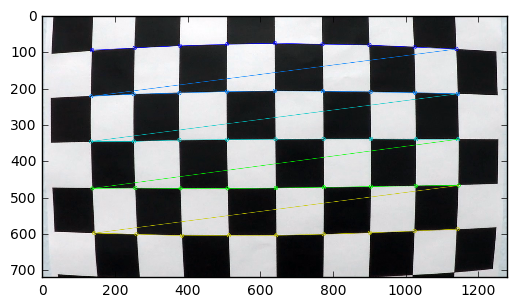

In [5]:
# prepare object points
nx = 9#TODO: enter the number of inside corners in x
ny = 5#TODO: enter the number of inside corners in y

objpoints = []
imgpoints = []

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)


# Make a list of calibration images
# img = mpimg.imread('resources/camera_cal/calibration1.jpg')
images = glob.glob('resources/camera_cal/*.jpg')

for idx, fname in enumerate(images):
    # Read in an image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

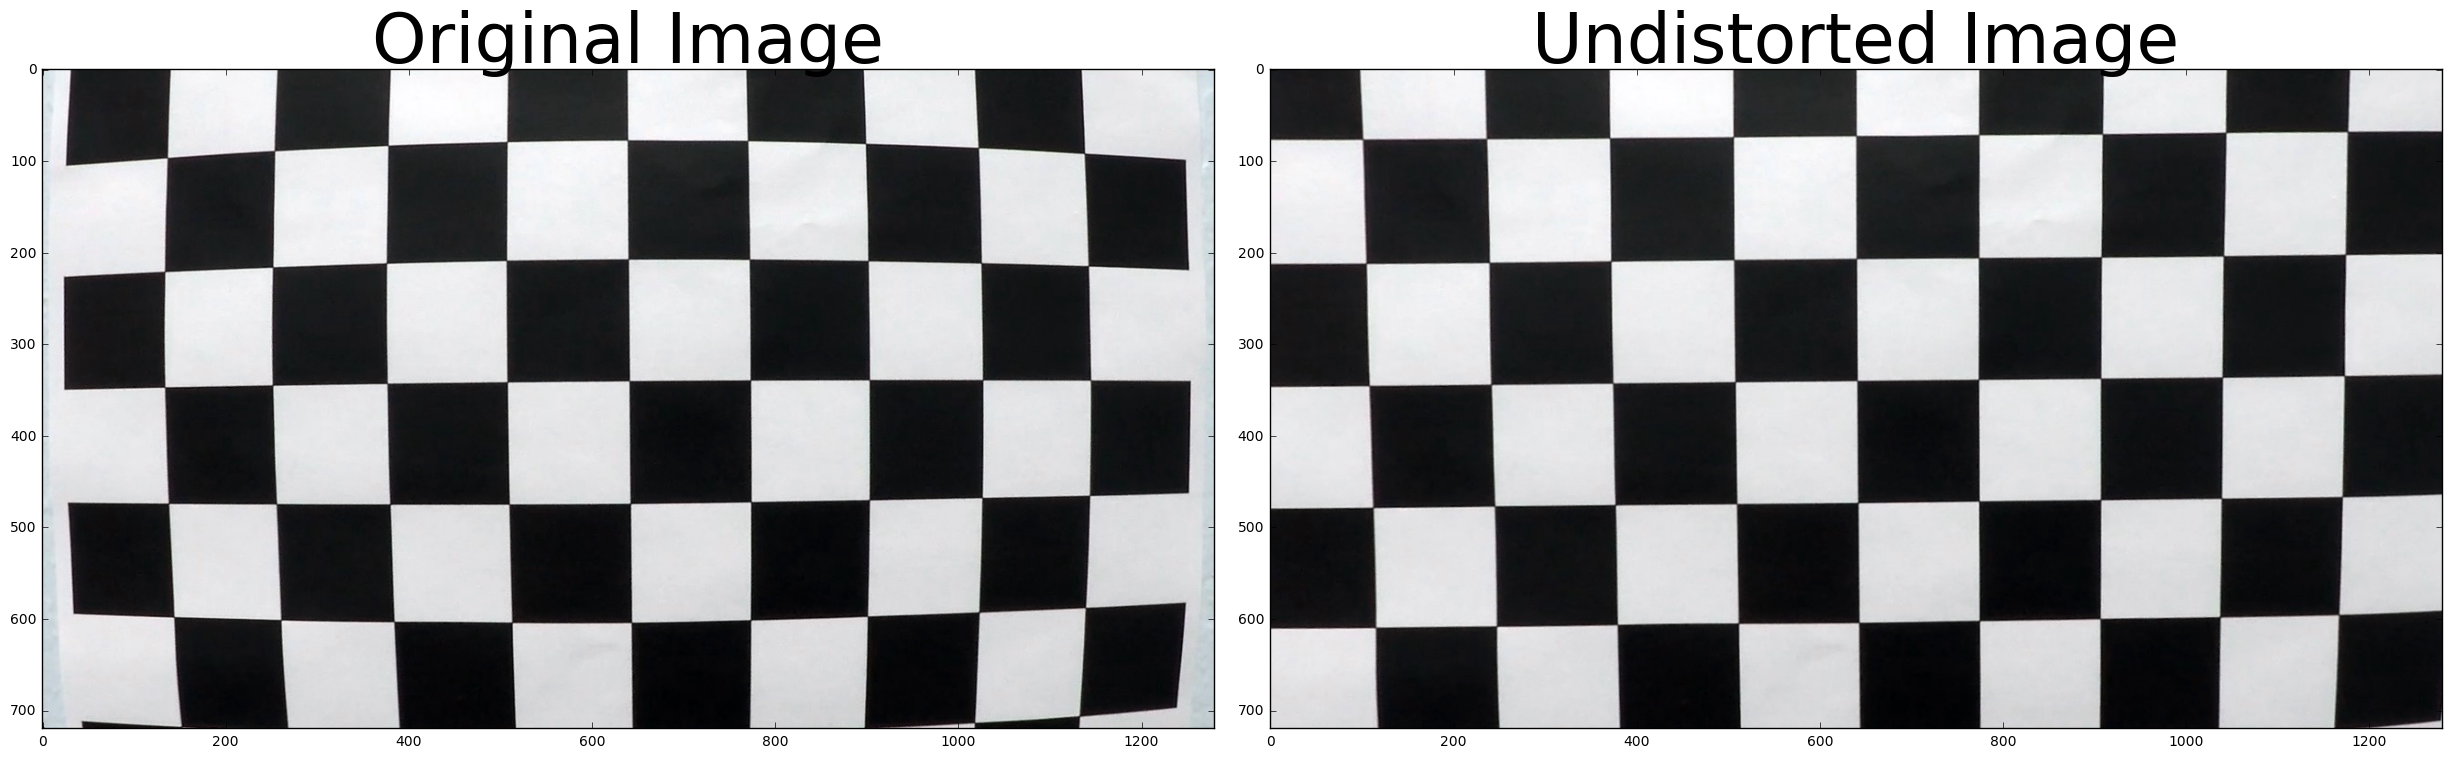

In [10]:
# Takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

# Get test image
img = cv2.imread('resources/camera_cal/calibration1.jpg')

undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [12]:
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_pickle.p", "wb" ) )

## Detect Lanes on an Image

This image is: <class 'numpy.ndarray'> with dimesions: (720, 1280, 3)


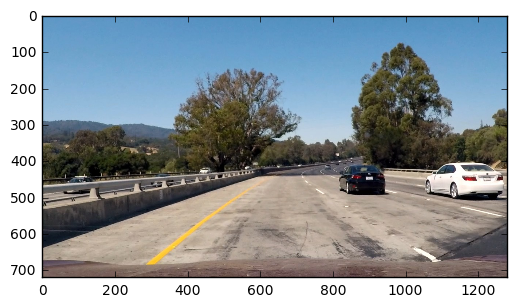

In [3]:
#reading in an image
# image = mpimg.imread('resources/test_images/solidWhiteRight.jpg')
image = mpimg.imread('resources/test_images/test1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def undograyscale(img):
    return cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def getSlope(line):
    for x1,y1,x2,y2 in line:
            return (y2-y1)/(x2-x1)

def getIntersect(line, slope):
    for x1,y1,x2,y2 in line:
        return y1 - slope * x1
    
def findFirstLineSlope(lines, isPos):
    for line in lines:
        slope = getSlope(line)
        if(slope > 0 and isPos):
            return slope
        elif(slope <= 0 and not isPos):
            return slope
    
def findFirstLineIntersect(lines, isPos):
    for line in lines:
        slope = getSlope(line)
        if(slope > 0 and isPos):
            return getIntersect(line, slope)
        elif(slope <= 0 and not isPos):
            return getIntersect(line, slope)
        
def averageList(list):
    return sum(list) / float(len(list))
    
def getLine(slope, intersect, maxX, minX):
    x1 = minX
    y1 = minX*slope + intersect
    x2 = maxX
    y2 = maxX*slope + intersect
    if(not math.isnan(x1) and not math.isnan(y1) and not math.isnan(x2) and not math.isnan(y2)):
        return [[int(x1), int(y1), int(x2), int(y2)]]
    else:
        return [[0, 0, 0, 0]]

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

/home/ckirksey/anaconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:96: RuntimeWarning: divide by zero encountered in int_scalars
/home/ckirksey/anaconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in double_scalars
/home/ckirksey/anaconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in double_scalars


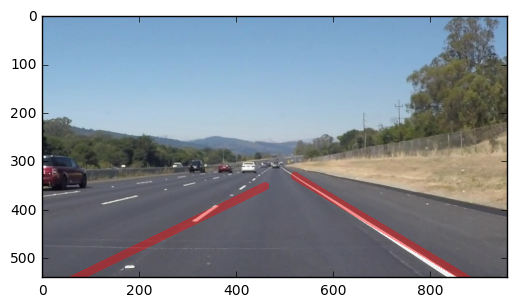

In [6]:
import os
import copy
image_list = os.listdir("resources/test_images/")
for image_reference in image_list:
    #set constants
    kernel_size = 7
    vertices = np.array( [[[0, 550],[500, 290],[940, 550]]], dtype=np.int32 )
    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_len = 15
    max_line_gap = 7
    low_threshold = 50
    high_threshold = 200
    
    #reading in an image
    image = mpimg.imread("resources/test_images/" + image_reference)
    initial_image = image
    
    #apply grayscale/gaussian blur/canny
    image = grayscale(image)
    image = gaussian_blur(image, kernel_size)
    image = canny(image, low_threshold, high_threshold)
    
    #isolate the region of interest
    image = region_of_interest(image, vertices)
    
    #get lines
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #average lines
    leftLineSlope = findFirstLineSlope(lines, True);
    leftLineB = findFirstLineIntersect(lines, True);
    rightLineSlope = findFirstLineSlope(lines, False);
    rightLineB = findFirstLineIntersect(lines, False);
    
    rightSlopes = []
    rightIntersects = []
    leftSlopes = []
    leftIntersects = []
    
    for line in lines:
        slope = getSlope(line)
        b = getIntersect(line, slope)
        if(slope < 0):
            rightSlopes.append(slope)
            rightIntersects.append(b)
        else:
            leftSlopes.append(slope)
            leftIntersects.append(b)
    
    image_with_lines = copy.deepcopy(initial_image)
    
    rightSlope = averageList(rightSlopes)
    rightIntersect = averageList(rightIntersects)
    leftSlope = averageList(leftSlopes)
    leftIntersect = averageList(leftIntersects)
    
    main_lines = [getLine(rightSlope, rightIntersect, 460, 0), getLine(leftSlope, leftIntersect, 1000, 520)]
    draw_lines(image_with_lines, main_lines, color=[255, 0, 0], thickness=15)
    
    #put lines back onto image
    image = undograyscale(image)

    final_image = weighted_img(image_with_lines, initial_image, α=0.6, β=0.4, λ=0.)
    
    plt.imshow(final_image, cmap='gray');  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    #set constants
    #set constants
    kernel_size = 7
    vertices = np.array( [[[0, 550],[500, 290],[940, 550]]], dtype=np.int32 )
    rho = 1
    theta = np.pi/180
    threshold = 1
    min_line_len = 15
    max_line_gap = 3
    low_threshold = 50
    high_threshold = 150
    
    #reading in an image
    initial_image = image
    
    #apply grayscale/gaussian blur/canny
    image = grayscale(image)
    image = gaussian_blur(image, kernel_size)
    image = canny(image, low_threshold, high_threshold)
    
    #isolate the region of interest
    image = region_of_interest(image, vertices)
    
    #get lines
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #average lines
    leftLineSlope = findFirstLineSlope(lines, True);
    leftLineB = findFirstLineIntersect(lines, True);
    rightLineSlope = findFirstLineSlope(lines, False);
    rightLineB = findFirstLineIntersect(lines, False);
    
    rightSlopes = []
    rightIntersects = []
    leftSlopes = []
    leftIntersects = []
    
    for line in lines:
        slope = getSlope(line)
        b = getIntersect(line, slope)
        if(slope < 0):
            rightSlopes.append(slope)
            rightIntersects.append(b)
        else:
            leftSlopes.append(slope)
            leftIntersects.append(b)
    
    image_with_lines = copy.deepcopy(initial_image)
    
    rightSlope = averageList(rightSlopes)
    rightIntersect = averageList(rightIntersects)
    leftSlope = averageList(leftSlopes)
    leftIntersect = averageList(leftIntersects)
    main_lines = [getLine(rightSlope, rightIntersect, 460, 0), getLine(leftSlope, leftIntersect, 1000, 520)]
    
    #draw lines
    draw_lines(image_with_lines, main_lines, color=[255, 0, 0], thickness=15)
    
    #put lines back onto image
    image = undograyscale(image)

    final_image = weighted_img(image_with_lines, initial_image, α=0.6, β=0.4, λ=0.)
    
    return final_image

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'resources/challenge_video_output.mp4'
clip1 = VideoFileClip("resources/challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video resources/challenge_video_output.mp4
[MoviePy] Writing video resources/challenge_video_output.mp4


100%|██████████| 485/485 [00:50<00:00,  9.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: resources/challenge_video_output.mp4 

CPU times: user 4min 40s, sys: 15.8 s, total: 4min 56s
Wall time: 52.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [249]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4





  0%|          | 0/682 [00:00<?, ?it/s]


  1%|          | 7/682 [00:00<00:10, 62.93it/s]


  2%|▏         | 14/682 [00:00<00:10, 64.46it/s]


  3%|▎         | 21/682 [00:00<00:10, 65.44it/s]


  4%|▍         | 28/682 [00:00<00:10, 65.20it/s]


  5%|▌         | 35/682 [00:00<00:09, 65.38it/s]


  6%|▌         | 42/682 [00:00<00:09, 65.97it/s]


  7%|▋         | 48/682 [00:00<00:10, 62.38it/s]


  8%|▊         | 54/682 [00:00<00:10, 59.68it/s]


  9%|▉         | 60/682 [00:00<00:10, 57.05it/s]


 10%|▉         | 66/682 [00:01<00:11, 54.55it/s]


 11%|█         | 72/682 [00:01<00:11, 53.26it/s]


 11%|█▏        | 78/682 [00:01<00:11, 52.65it/s]


 12%|█▏        | 84/682 [00:01<00:11, 52.81it/s]


 13%|█▎        | 90/682 [00:01<00:11, 52.66it/s]


 14%|█▍        | 96/682 [00:01<00:11, 51.90it/s]


 15%|█▍        | 102/682 [00:01<00:11, 50.44it/s]


 16%|█▌        | 108/682 [00:01<00:12, 47.80it/s]


 17%|█▋        | 113/682 [00:02<00:14, 40.36it/s]


 17%|█▋        | 118/682 [00:02<00:

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.2 s, sys: 7.72 s, total: 17.9 s
Wall time: 16.5 s


In [250]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

My lane finding algorithm starts by converting the current image to gray scale, then applying a Gaussian blur and Canny transform to the image for easier processing. 

Afterwards it isolates the image to focus only on the area of the image containing the road. This isolated region is specified with staticly defined vertices. A future improvement could leverage shape/color detection to programmatically select the region of interest. 

Next it finds Hough lines in that isolated region. It splits this collection of lines into groups with positive and negatives slopes (since each side of the road should have either a positive or negative slope). This is a limitation in the algorithm as on an extreme curve the slope of both lane markers could become positive/negative. In the future it would be good to use a more dynamic grouping mechanism. It then averages the slope and intersect of the two groups to get lines representing the two sides of the lane.

Finally, it draws those lines onto the image. Currently I'm hardcoding the initial and final x-coordinates for the two lines in order to get a stable line. Eventually it would be good to do more intelligent horizon detection and draw the lanes from the bottom edge of the frame to the horizon of the road in the image.


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [247]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4





  0%|          | 0/251 [00:00<?, ?it/s]


  2%|▏         | 4/251 [00:00<00:06, 37.76it/s]


  4%|▎         | 9/251 [00:00<00:06, 38.74it/s]


  5%|▌         | 13/251 [00:00<00:06, 39.10it/s]


  7%|▋         | 18/251 [00:00<00:05, 39.89it/s]


  9%|▉         | 22/251 [00:00<00:05, 38.96it/s]


 11%|█         | 27/251 [00:00<00:05, 39.85it/s]


 13%|█▎        | 32/251 [00:00<00:05, 40.44it/s]


 15%|█▍        | 37/251 [00:00<00:05, 40.85it/s]


 16%|█▋        | 41/251 [00:01<00:05, 40.53it/s]


 18%|█▊        | 45/251 [00:01<00:05, 39.73it/s]


 20%|█▉        | 49/251 [00:01<00:05, 37.75it/s]


 21%|██        | 53/251 [00:01<00:05, 33.35it/s]


 23%|██▎       | 57/251 [00:01<00:07, 25.69it/s]


 24%|██▍       | 60/251 [00:01<00:07, 24.03it/s]


 25%|██▌       | 63/251 [00:01<00:08, 23.49it/s]


 26%|██▋       | 66/251 [00:02<00:07, 24.60it/s]


 27%|██▋       | 69/251 [00:02<00:07, 24.36it/s]


 29%|██▊       | 72/251 [00:02<00:07, 23.42it/s]


 30%|██▉       | 75/251 [00:02<00:07, 2

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.52 s, sys: 3.34 s, total: 9.86 s
Wall time: 11.4 s


In [248]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))